In [1]:
from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.device_manager import DeviceManager
from swiper2.window_builder import WindowBuilder
from swiper2.window_manager import SlidingWindowManager
from swiper2.decoder_manager import DecoderManager
from swiper2.simulator import DecodingSimulator
import swiper2.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [3]:
scheduling_method = 'parallel'

# Sliding Window Scheme

## Regular T Schedule, instant bad speculations

In [4]:
d=7
decoding_time = 2*d
# speculation_time = 100*d
speculation_time = 0
speculation_accuracy = 0

In [5]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [6]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)
success

Surface code rounds: 117it [00:00, 13884.10it/s]


True

In [7]:
MemorySchedule(100).schedule.total_duration(5)

100

In [8]:
decoding_data.num_rounds

117

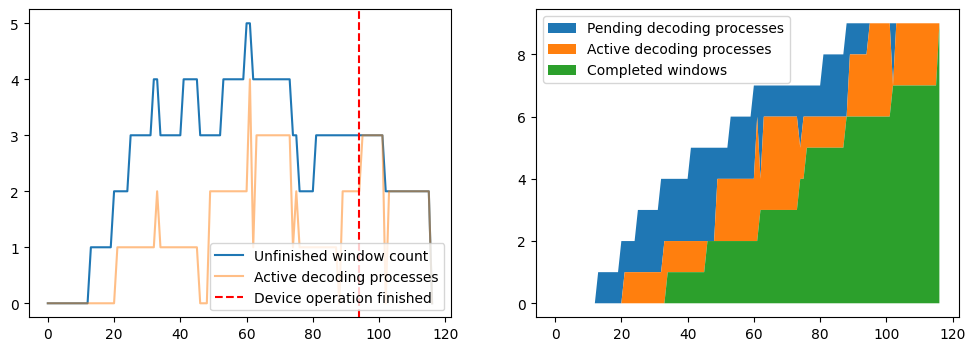

In [9]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending decoding processes')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active decoding processes')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe a significant amount of redundant work (many decoding processes
happening in parallel, but number of completed windows is only increasing
gradually - because most of the decoding processes are based on faulty
speculations and must be recomputed later)

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [10]:
d=7
decoding_time = 2*d
speculation_time = 100*d
# speculation_time = 0
speculation_accuracy = 0

In [11]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [12]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 117it [00:00, 13168.40it/s]


In [13]:
decoding_data.num_rounds

117

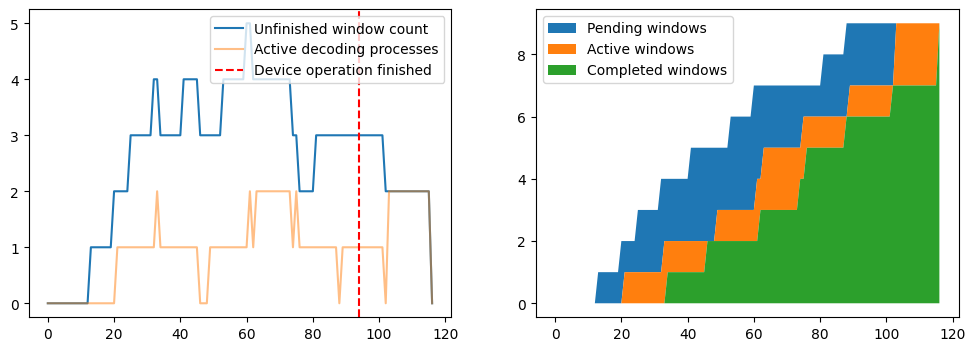

In [14]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe that the number of active decoding processes is far lower, but the rate
of completing windows remains the same.

<Axes3D: >

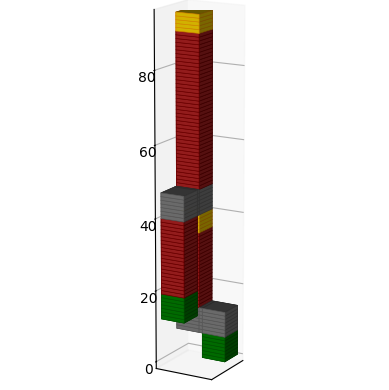

In [15]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

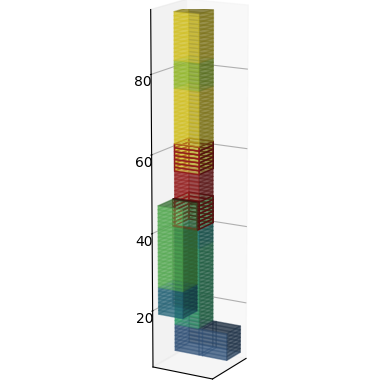

In [16]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[5]
)


    def _split_windows(
            self,
            window: DecodingWindow,
            source_commit_regions: list[SpacetimeRegion],
            sink_commit_regions: list[SpacetimeRegion],
            enforce_contiguous: bool = True,
        ) -> tuple[DecodingWindow, DecodingWindow]:
        """Split a window into two windows that each contain some of the commit
        regions of the original window. The original window is removed from
        all_windows, and the new windows are added.

        Buffer dependency relationships of the original window are preserved in
        the new windows. The first new window will be a parent ("source") of the
        second new window ("sink").

        Args:
            window: Window to split
            source_commit_regions: Commit regions for the first new window.
            sink_commit_regions: Commit regions for the second new window (the
                sink). This window will be a dependency of the first new window.
            enforce_contiguous: If True, the source and sink commit regions must
                be contiguous in spacetime. If False, the source commit regions
                can be non-contiguous.
        """
        window_idx = self.all_windows.index(window)
        assert not window.constructed
        assert set(source_commit_regions) | set(sink_commit_regions) == set(window.commit_region)
        assert len(source_commit_regions) > 0
        assert len(sink_commit_regions) > 0

        if enforce_contiguous:
            if not self._is_contiguous(source_commit_regions):
                raise ValueError("Source commit regions must be contiguous")
            if not self._is_contiguous(sink_commit_regions):
                raise ValueError("Sink commit regions must be contiguous")

        source_buffers = set()
        sink_buffers = set()
        for region in window.buffer_regions:
            if any(region.shares_boundary(cr) for cr in source_commit_regions):
                source_buffers.add(region)
            if any(region.shares_boundary(cr) for cr in sink_commit_regions):
                sink_buffers.add(region)

        # Construct new windows
        source_window = DecodingWindow(
            tuple(source_commit_regions),
            frozenset(source_buffers),
            window.merge_instr,
            window.parent_instr_idx,
            window.constructed,
        )
        sink_window = DecodingWindow(
            tuple(sink_commit_regions),
            frozenset(sink_buffers),
            window.merge_instr,
            window.parent_instr_idx,
            window.constructed,
        )

        predecessors = list(self.window_dag.predecessors(window_idx))
        successors = list(self.window_dag.successors(window_idx))
        predecessors_source = []
        predecessors_sink = []
        successors_source = []
        successors_sink = []
        for node in predecessors:
            w = self.all_windows[node]
            if source_window.shares_boundary(w):
                predecessors_source.append(node)
            if sink_window.shares_boundary(w):
                predecessors_sink.append(node)
        for node in successors:
            w = self.all_windows[node]
            if source_window.shares_boundary(w):
                successors_source.append(node)
            if sink_window.shares_boundary(w):
                successors_sink.append(node)

        # Add new windows to all_windows and update data structures
        self.all_windows[window_idx] = source_window
        self.window_dag.remove_edges_from([p for p in predecessors if p not in predecessors_source])
        self.window_dag.remove_edges_from([s for s in successors if s not in successors_source])
        
        self.all_windows.append(sink_window)
        sink_idx = len(self.all_windows) - 1
        self.window_dag.add_edges_from([(p, sink_idx) for p in predecessors_sink])
        self.window_dag.add_edges_from([(sink_idx, s) for s in successors_sink])
        self.window_buffer_wait[sink_idx] = self.window_buffer_wait[window_idx]
        
        source_cr_indices = [i for i,cr in enumerate(window.commit_region) if cr in source_commit_regions]
        sink_cr_indices = [i for i,cr in enumerate(window.commit_region) if cr in sink_commit_regions]
        for k,(w_idx,cr_idx) in self.window_end_lookup.items():
            if w_idx == window_idx:
                if cr_idx in sink_cr_indices:
                    self.window_end_lookup[k] = (sink_idx, cr_idx - len(source_commit_regions))
                else:
                    assert cr_idx in source_cr_indices
        return source_window, sink_window

## 15 - 1 Factory

<font color=red>VERIFY CORRECTNESS</font>

In [17]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [18]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [19]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 133it [00:00, 672.83it/s]


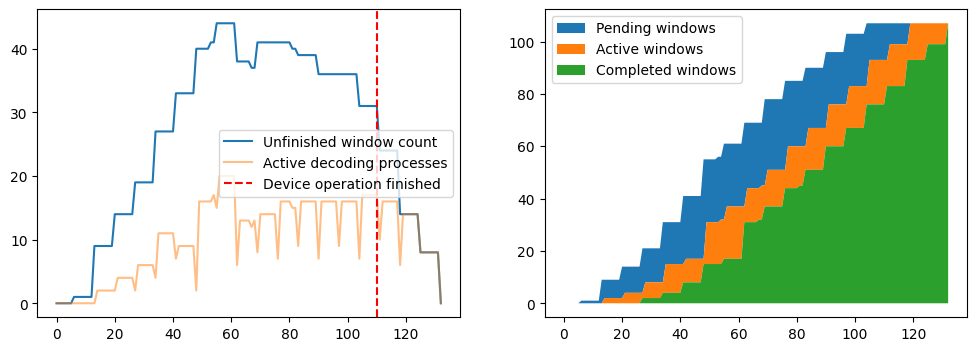

In [20]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

<Axes3D: >

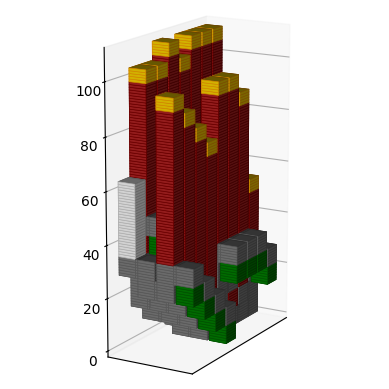

In [21]:
plotter.plot_device_schedule_trace(device_data, spacing=1)

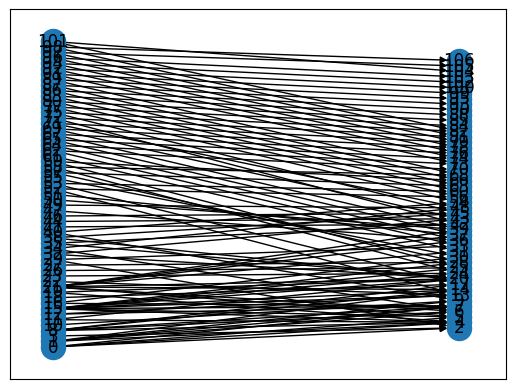

In [22]:
draw_dag(window_data.window_dag)

In [23]:
a = True
a &= True
a

True

<Axes3D: >

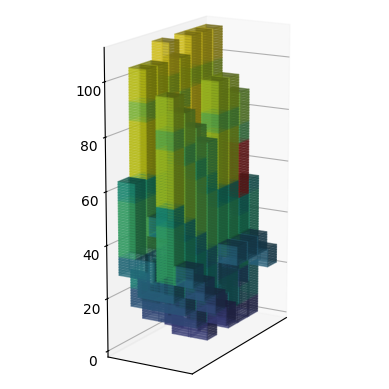

In [24]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    spacing=1,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[56]
)

# Stress test

In [25]:
d=7
decoding_time = 2*d
speculation_time = 2
speculation_accuracy = 0.7

In [26]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [27]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(100, 0).schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 4960it [00:17, 280.53it/s]

4922 4960


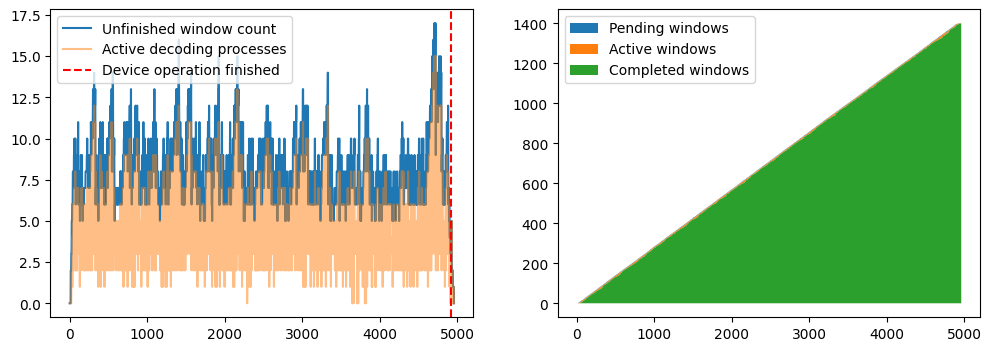

In [28]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()